In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from defaults.plot import *
enable_latex_export()

In [2]:
import torch
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import flows.utils as utils
from sklearn.preprocessing import StandardScaler

from observations.dimensions.one.multimodal import *

X_bimodal = simulate_bimodal()

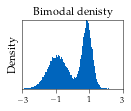

In [3]:
plt.title('Bimodal denisty')
plt.hist(X_bimodal, bins=250, density=True, rasterized=True)
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
no_axis(x=True)
plt.savefig("figures/nfs/bimodal.pdf", dpi=dpi)
plt.show()

In [4]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_bimodal = T.Spline(1, count_bins=16)
flow_dist_bimodal = dist.TransformedDistribution(base_dist, [spline_transform_bimodal])

steps = 2001
dataset = torch.tensor(X_bimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_bimodal.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_bimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_bimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.001404285430908
step: 200, loss: 1.187933087348938
step: 400, loss: 1.1821526288986206
step: 600, loss: 1.1803009510040283
step: 800, loss: 1.1793135404586792
step: 1000, loss: 1.1786741018295288
step: 1200, loss: 1.1782102584838867
step: 1400, loss: 1.1779296398162842
step: 1600, loss: 1.1777276992797852
step: 1800, loss: 1.1775667667388916
step: 2000, loss: 1.1774370670318604
Wall time: 3min 17s


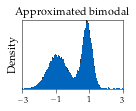

In [5]:
plt.title('Approximated bimodal')
plt.hist(X_bimodal, bins=250, density=True, label='Target Distribution', color=TUMDarkGray, rasterized=True)
plt.hist(flow_dist_bimodal.sample(torch.Size([50000])).detach().numpy(), bins=250, density=True, label='New Samples', color=TUMBlue, rasterized=True)
#plt.legend()
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
no_axis(x=True)
plt.savefig("figures/nfs/bimodal-sampled.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

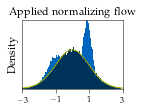

In [6]:
import scipy.stats as stats
import math

plt.title('Applied normalizing flow')
plt.hist(X_bimodal, bins=250, density=True, label='Target Distribution', color=TUMBlue, rasterized=True)
plt.hist(spline_transform_bimodal.inv(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label='Normalized Target', color=TUMSecondaryBlue2, rasterized=True)

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(-3, 3, 250)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)

plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.xticks([-3, -1, 1, 3])

#plt.legend()
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.savefig("figures/nfs/bimodal-nf.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

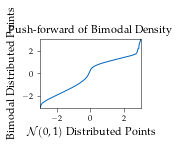

In [7]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy()

plt.title("Push-forward of Bimodal Density")
plt.plot(input, mapped, color=TUMBlue)

plt.xlabel(r"$\mathcal{N}(0,1)$ Distributed Points")
plt.ylabel("Bimodal Distributed Points")
plt.xlim(-3, 3)

plt.savefig("figures/nfs/bimodal-pushforward.pdf", dpi=dpi)
plt.show()
#print(mapped[5000])

In [8]:
X_trimodal = simulate_trimodal()

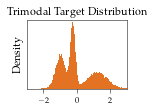

In [9]:
plt.title('Trimodal Target Distribution')
plt.hist(X_trimodal, bins=250, color=TUMAccentOrange, rasterized=True)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/trimodal.pdf", dpi=dpi)
plt.show()

In [10]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_trimodal = T.Spline(1, count_bins=26) # TODO: we need more bins for trimodal, to better approximate it
flow_dist_trimodal = dist.TransformedDistribution(base_dist, [spline_transform_trimodal])

steps = 3001
dataset = torch.tensor(X_trimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_trimodal.parameters(), lr=8e-3)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_trimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_trimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.5755093097686768
step: 200, loss: 1.1912767887115479
step: 400, loss: 1.17750883102417
step: 600, loss: 1.1753414869308472
step: 800, loss: 1.1745836734771729
step: 1000, loss: 1.1742050647735596
step: 1200, loss: 1.1739569902420044
step: 1400, loss: 1.1737748384475708
step: 1600, loss: 1.1736397743225098
step: 1800, loss: 1.173532247543335
step: 2000, loss: 1.1734446287155151
step: 2200, loss: 1.173344612121582
step: 2400, loss: 1.173257827758789
step: 2600, loss: 1.173148274421692
step: 2800, loss: 1.1730705499649048
step: 3000, loss: 1.1730180978775024
Wall time: 10min 8s


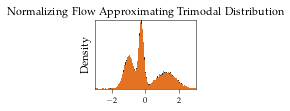

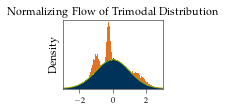

In [11]:
plt.title('Normalizing Flow Approximating Trimodal Distribution')
plt.hist(X_trimodal, bins=250, density=True, label='Target Distribution', color=TUMDarkGray, rasterized=True)
plt.hist(flow_dist_trimodal.sample(torch.Size([50000])).detach().numpy(), bins=250, density=True, label='New Samples', color=TUMAccentOrange, rasterized=True)
#plt.legend()
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/trimodal-sampled.pdf", dpi=dpi)
plt.show()

plt.title('Normalizing Flow of Trimodal Distribution')
plt.hist(X_trimodal, bins=250, density=True, label='Target Distribution', color=TUMAccentOrange, rasterized=True)
plt.hist(spline_transform_trimodal.inv(torch.tensor(X_trimodal)).detach().numpy(), bins=250, density=True, label='Normalized Target', color=TUMSecondaryBlue2, rasterized=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
#plt.legend()
plt.savefig("figures/nfs/trimodal-nf.pdf", dpi=dpi)
plt.show()

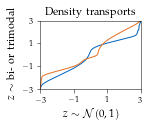

In [12]:
input = np.linspace(-3, 3, 10000)

plt.title("Density transports")
plt.plot(input, spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "Bimodal", color=TUMBlue)
plt.plot(input, spline_transform_trimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "Trimodal", color=TUMAccentOrange)
plt.xlabel(r"$z \sim \mathcal{N}(0,1)$")
plt.ylabel("$z \sim$ bi- or trimodal")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
plt.yticks([-3, -1, 1, 3])
#no_axis(x=True)
#plt.legend()

plt.savefig("figures/nfs/bimodal-and-trimodal-pushforward.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

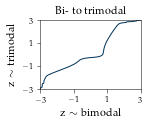

In [13]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal.inv(torch.tensor([[x] for x in input]))
mapped = spline_transform_trimodal(torch.tensor([[x] for x in mapped]))

plt.title("Bi- to trimodal")
plt.plot(input, mapped.detach().numpy(), color=TUMSecondaryBlue2)
plt.xlabel(r"z $\sim$ bimodal")
plt.ylabel(r"z $\sim$ trimodal")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
plt.yticks([-3, -1, 1, 3])
plt.savefig("figures/nfs/bimodal-to-trimodal-pushforward.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

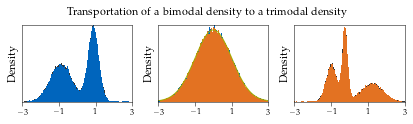

In [21]:
from matplotlib.patches import Patch

plt.subplots(1, 3, figsize=(5.8, 1.8))
ttl = plt.gcf().suptitle("Transportation of a bimodal density to a trimodal density", fontsize=10.95)
ttl.set_position([0.5, 0.92])
#ttl.set_position([0.5, 1.2])

#TODO legends=
#plt.gca().legend(handles = [Patch(facecolor=TUMBlue, label='Color Patch')], loc="lower center")

plt.subplot(1, 3, 1, aspect='auto')
#plt.title('Bimodal Target Distribution', y=-0.01)
plt.hist(X_bimodal, bins=200, density=True, color=TUMDarkGray, rasterized=True)
plt.hist(spline_transform_bimodal(spline_transform_trimodal.inv(torch.tensor(X_trimodal))).detach().numpy(), bins=250, density=True, label="Trimodal Samples", color=TUMBlue, rasterized=True)
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
no_axis(x=True)

plt.subplot(1, 3, 2, aspect='auto')
#plt.title('Normalized Data', y=-0.01)
plt.hist(spline_transform_bimodal.inv(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label='Normalized Bimodal', color=TUMBlue, rasterized=True)
plt.hist(spline_transform_trimodal.inv(torch.tensor(X_trimodal)).detach().numpy(), bins=250, density=True, label='Normalized Trimodal', color=TUMAccentOrange, rasterized=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
no_axis(x=True)
#plt.legend()

plt.subplot(1, 3, 3, aspect='auto')
#plt.title('Trimodal Target Distribution',y=-0.01)
plt.hist(X_trimodal, bins=250, color=TUMDarkGray, density=True, rasterized=True)
plt.hist(spline_transform_trimodal(spline_transform_bimodal.inv(torch.tensor(X_bimodal))).detach().numpy(), bins=250, density=True, color=TUMAccentOrange, rasterized=True)
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.xticks([-3, -1, 1, 3])
no_axis(x=True)

plt.tight_layout()
plt.savefig("figures/nfs/bimodal-to-trimodal-explained.pdf", dpi=dpi, bbox_inches="tight")
plt.show()

step: 0, loss: 2.526124954223633
step: 200, loss: 1.189894676208496
step: 400, loss: 1.1816147565841675
step: 600, loss: 1.1795520782470703
step: 800, loss: 1.178525686264038
step: 1000, loss: 1.1779568195343018
step: 0, loss: 2.554039239883423
step: 200, loss: 1.1910988092422485
step: 400, loss: 1.1778898239135742
step: 600, loss: 1.1750569343566895
step: 800, loss: 1.1739966869354248
step: 1000, loss: 1.1735165119171143


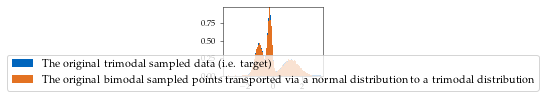

In [15]:
# Now the same but with the utils function
bimodal_to_trimodal = utils.samples_to_samples(X_bimodal, X_trimodal)

plt.hist(X_trimodal, bins=250, density=True, label='The original trimodal sampled data (i.e. target)', rasterized=True)
plt.hist(bimodal_to_trimodal(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label="The original bimodal sampled points transported via a normal distribution to a trimodal distribution", rasterized=True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

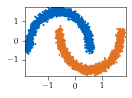

In [16]:
# Now instead of a single step, we use multiple spline transforms in concatenation

from sklearn.datasets import make_moons
X, colors = make_moons(n_samples=5000, noise=0.05)
colors = [TUMBlue if c == 0 else TUMAccentOrange for c in colors]

X = StandardScaler().fit_transform(X)

plt.scatter(X[:,0], X[:, 1], c=colors, s=1)
plt.show()

In [52]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
transforms = []
count_bins = [6, 6, 6]
[transforms.append(T.spline_coupling(2, count_bins=b)) for b in count_bins]

flow_dist = dist.TransformedDistribution(base_dist, transforms)

parameters = sum([list(t.parameters()) for t in transforms], [])

step: 0, loss: 11.896139144897461
step: 200, loss: 1.347143292427063
step: 400, loss: 1.2517502307891846
step: 600, loss: 1.1997997760772705
step: 800, loss: 1.2002781629562378
step: 1000, loss: 1.1798570156097412
step: 1200, loss: 1.1738758087158203
step: 1400, loss: 1.1588412523269653
step: 1600, loss: 1.164775013923645


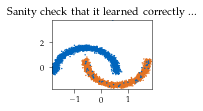

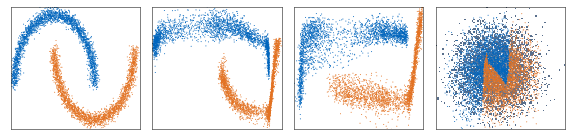

Wall time: 1min 32s


In [53]:
%%time
steps = 1601
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(parameters, lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

X_sampled = flow_dist.sample(torch.Size([100,])).detach().numpy()
plt.title("Sanity check that it learned correctly ... ")
plt.scatter(X[:,0], X[:, 1], c=colors, edgecolor='none', s=2)
plt.scatter(X_sampled[:,0], X_sampled[:, 1], edgecolor='none', s=2)
plt.show()

num_transforms = len(count_bins)

working_X = dataset
normal_test = base_dist.sample(torch.Size([5000,])).detach().numpy()

s = 1
fig, axs = plt.subplots(1, num_transforms+1, figsize=(2*(num_transforms+1), 2))
i = 0
for t in reversed(transforms):
    axs[i].scatter(working_X.detach().numpy()[:,0], working_X.detach().numpy()[:, 1], c=colors, s=s, edgecolors="none", rasterized=True)
    working_X = t.inv(working_X)
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    i += 1

axs[i].hist2d(normal_test[:,0], normal_test[:,1], bins=100, cmin=1, alpha=0.65, cmap='cividis', rasterized=True)
#axs[i].scatter(normal_test[:,0], normal_test[:,1], edgecolors="none", alpha=0.6, color="black", s=s, rasterized=True)
axs[i].scatter(working_X.detach().numpy()[:,0], working_X.detach().numpy()[:, 1], edgecolors="none", c=colors, s=s, rasterized=True)
axs[i].axes.xaxis.set_ticks([])
axs[i].axes.yaxis.set_ticks([])
#fig.suptitle("Transporting Moons to a Normal Distribution")
plt.tight_layout()
plt.savefig("figures/nfs/moons-to-normal.pdf", dpi=dpi)
plt.show()